In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# European Housing Trends — Exploration

This notebook combines **five Eurostat datasets** (already tidied to CSV with `scripts/ingest_eurostat_csvs.py`):

- House Price Index (HPI)
- Net Earnings
- Unemployment Rate
- Inflation (HICP index)
- GDP per capita

Each file already has:
- `country`  
- `year`  
- `value` -> dataset-specific column (`house_price_index`, `net_earnings`, etc.)  
- `unit`

**Goals:**
1. Load and merge all datasets into a single DataFrame with readable column names.
2. Explore Europe‑wide patterns (correlations & simple plots).
3. Look specifically at **Bulgaria**.

In [2]:
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (7, 5)

PROC = Path("../data/processed")

list(PROC.glob("*.csv"))

[WindowsPath('../data/processed/gdp_per_capita_tidy.csv'),
 WindowsPath('../data/processed/house_price_index_tidy.csv'),
 WindowsPath('../data/processed/inflation_hicp_tidy.csv'),
 WindowsPath('../data/processed/net_earnings_tidy.csv'),
 WindowsPath('../data/processed/unemployment_rate_tidy.csv')]

## Load all tidy CSVs

Each dataset already have proper named columns.

In [3]:
hpi   = pd.read_csv(PROC / "house_price_index_tidy.csv")
earn  = pd.read_csv(PROC / "net_earnings_tidy.csv")
unemp = pd.read_csv(PROC / "unemployment_rate_tidy.csv")
hicp  = pd.read_csv(PROC / "inflation_hicp_tidy.csv")
gdp   = pd.read_csv(PROC / "gdp_per_capita_tidy.csv")

hpi.head()

,country,year,value,unit
0,Austria,2015,128.63,"Annual average index, 2010=100"
1,Austria,2016,136.27,"Annual average index, 2010=100"
2,Austria,2017,144.48,"Annual average index, 2010=100"
3,Austria,2018,153.57,"Annual average index, 2010=100"
4,Austria,2019,162.82,"Annual average index, 2010=100"


## Merge everything into one DataFrame

We **inner‑join** on `country` and `year` so the final table has only rows present in **all** datasets:

Final columns:
- `country`, `year`
- `house_price_index`, `net_earnings`, `unemployment_rate`, `hicp_index`, `gdp_per_capita`
- Plus a computed `real_earnings` = `net_earnings` adjusted for HICP (2015=100 base typical).


In [4]:
hpi_ = hpi.rename(columns={"value": "house_price_index"})
earn_ = earn.rename(columns={"value": "net_earnings"})
unemp_ = unemp.rename(columns={"value": "unemployment_rate"})
hicp_ = hicp.rename(columns={"value": "hicp_index"})
gdp_ = gdp.rename(columns={"value": "gdp_per_capita"})


In [13]:
df = (
    hpi_[["country", "year", "house_price_index"]]
    .merge(earn_[["country", "year", "net_earnings"]], on=["country", "year"], how="inner")
    .merge(unemp_[["country", "year", "unemployment_rate"]], on=["country", "year"], how="inner")
    .merge(hicp_[["country", "year", "hicp_index"]], on=["country", "year"], how="inner")
    .merge(gdp_[["country", "year", "gdp_per_capita"]], on=["country", "year"], how="inner")
    .copy()
)

# Real earnings: deflate by HICP index (index / 100)
df["real_earnings"] = df["net_earnings"] / (df["hicp_index"] / 100.0)

df.head(), df.shape

(   country  year  house_price_index  net_earnings  unemployment_rate  \
 0  Austria  2015             128.63      34414.48                6.1   
 1  Austria  2016             136.27      36707.82                6.5   
 2  Austria  2017             144.48      37220.14                5.9   
 3  Austria  2018             153.57      37847.53                5.2   
 4  Austria  2019             162.82      41162.12                4.8   
 
    hicp_index  gdp_per_capita  real_earnings  
 0      100.00         39640.0   34414.480000  
 1      100.97         40690.0   36355.174804  
 2      103.22         41760.0   36059.038946  
 3      105.41         43360.0   35905.065933  
 4      106.98         44570.0   38476.462890  ,
 (297, 8))

## Save the merged dataset

We save the combined CSV for reuse in future notebooks / scripts.

In [15]:
merged_path = PROC / "merged_all.csv"
df.to_csv(merged_path, index=False)
merged_path


WindowsPath('../data/processed/merged_all.csv')

## Basic sanity checks

- Structure (`.info()`), summary statistics (`.describe()`), and country coverage.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            297 non-null    object 
 1   year               297 non-null    int64  
 2   house_price_index  297 non-null    float64
 3   net_earnings       297 non-null    float64
 4   unemployment_rate  297 non-null    float64
 5   hicp_index         297 non-null    float64
 6   gdp_per_capita     297 non-null    float64
 7   real_earnings      297 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 18.7+ KB


In [19]:
df.describe()

,year,house_price_index,net_earnings,unemployment_rate,hicp_index,gdp_per_capita,real_earnings
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,2019.511785,153.873064,26657.342357,6.770707,114.657104,34512.323232,24064.735477
std,2.860618,132.313394,14706.286192,2.896663,34.175302,22773.930976,13457.278514
min,2015.000000,71.090000,4860.670000,2.000000,98.680000,6560.000000,1535.765580
25%,2017.000000,108.420000,13702.450000,4.900000,101.700000,17600.000000,11943.611155
50%,2020.000000,135.130000,23386.320000,6.300000,105.930000,28920.000000,21536.262009
75%,2022.000000,168.480000,38180.360000,7.900000,118.980000,43680.000000,36159.428122
max,2024.000000,2066.460000,67125.600000,22.100000,570.940000,126910.000000,56288.822808


In [20]:
df["country"].nunique(), sorted(df["country"].unique())[:12]

(30,
 ['Austria',
  'Belgium',
  'Bulgaria',
  'Croatia',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Estonia',
  'Euro area – 20 countries (from 2023)',
  'European Union - 27 countries (from 2020)',
  'Finland',
  'France'])

In [21]:
earn = pd.read_csv(PROC / "net_earnings_tidy.csv")

hpi_ = hpi.rename(columns={"value": "house_price_index"})
earn_ = earn.rename(columns={"value": "net_earnings"})

hpi_.head(), earn_.head()

(   country  year  house_price_index                            unit
 0  Austria  2015             128.63  Annual average index, 2010=100
 1  Austria  2016             136.27  Annual average index, 2010=100
 2  Austria  2017             144.48  Annual average index, 2010=100
 3  Austria  2018             153.57  Annual average index, 2010=100
 4  Austria  2019             162.82  Annual average index, 2010=100,
    country  year  net_earnings
 0  Austria  2015      34414.48
 1  Austria  2016      36707.82
 2  Austria  2017      37220.14
 3  Austria  2018      37847.53
 4  Austria  2019      41162.12)

## Europe‑wide quick exploration

We start with:
- **Correlation matrix** for key variables.
- A few **scatter plots** to visualize relationships.

In [23]:
corr = df[[
    "house_price_index",
    "net_earnings",
    "real_earnings",
    "unemployment_rate",
    "gdp_per_capita",
]].corr()
corr

,house_price_index,net_earnings,real_earnings,unemployment_rate,gdp_per_capita
house_price_index,1.000000,-0.080634,-0.151667,-0.045603,-0.033335
net_earnings,-0.080634,1.000000,0.980374,-0.214378,0.928200
real_earnings,-0.151667,0.980374,1.000000,-0.162719,0.904658
unemployment_rate,-0.045603,-0.214378,-0.162719,1.000000,-0.239864
gdp_per_capita,-0.033335,0.928200,0.904658,-0.239864,1.000000


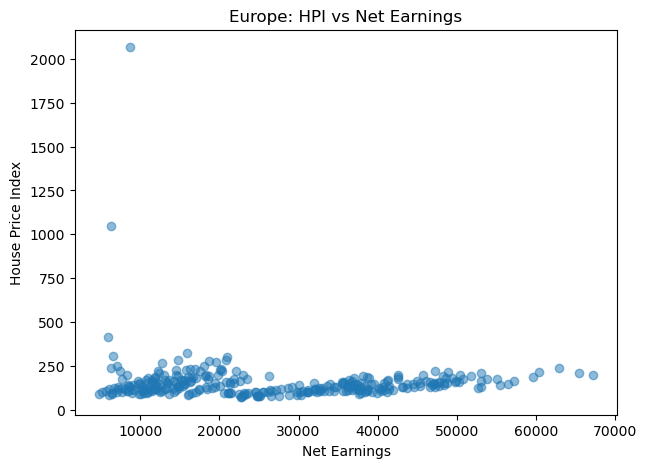

In [25]:
plt.figure()
plt.scatter(df["net_earnings"], df["house_price_index"], alpha=0.5)
plt.xlabel("Net Earnings")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs Net Earnings")
plt.show()

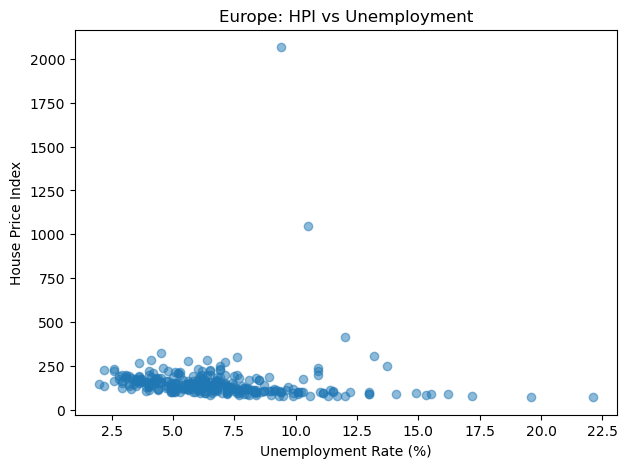

In [26]:
plt.figure()
plt.scatter(df["unemployment_rate"], df["house_price_index"], alpha=0.5)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs Unemployment")
plt.show()

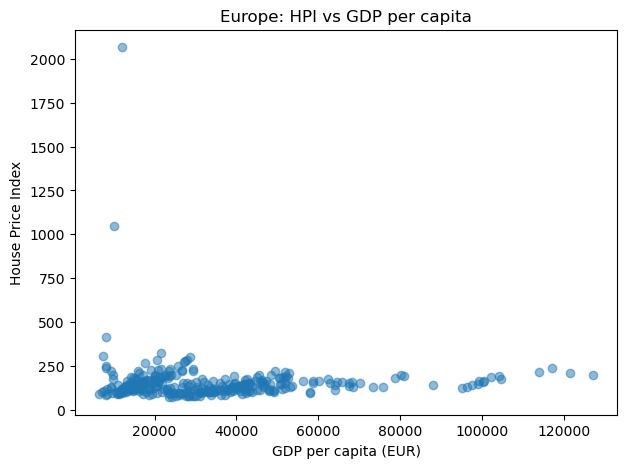

In [27]:
plt.figure()
plt.scatter(df["gdp_per_capita"], df["house_price_index"], alpha=0.5)
plt.xlabel("GDP per capita (EUR)")
plt.ylabel("House Price Index")
plt.title("Europe: HPI vs GDP per capita")
plt.show()

## Focus on Bulgaria

Let’s filter the merged DataFrame to **Bulgaria** and explore:
- Basic table
- Lines over time for each indicator

In [28]:
bg = df[df["country"] == "Bulgaria"].sort_values("year").copy()
bg

,country,year,house_price_index,net_earnings,unemployment_rate,hicp_index,gdp_per_capita,real_earnings
20,Bulgaria,2015,92.29,4860.67,10.1,100.00,6560.0,4860.670000
21,Bulgaria,2016,99.07,5231.03,8.6,98.68,7070.0,5301.003243
22,Bulgaria,2017,108.70,5674.72,7.2,99.85,7720.0,5683.244867
23,Bulgaria,2018,116.35,6019.75,6.2,102.48,8360.0,5874.072990
24,Bulgaria,2019,121.93,6665.67,5.2,104.99,9270.0,6348.861796
25,Bulgaria,2020,129.22,7185.43,6.1,106.27,9450.0,6761.484897
26,Bulgaria,2021,141.15,8469.05,5.2,109.30,10970.0,7748.444648
27,Bulgaria,2022,163.17,9704.27,4.2,123.52,13310.0,7856.436205
28,Bulgaria,2023,180.44,11043.88,4.3,134.15,14690.0,8232.486023
29,Bulgaria,2024,208.82,12362.37,4.2,137.63,16110.0,8982.322168


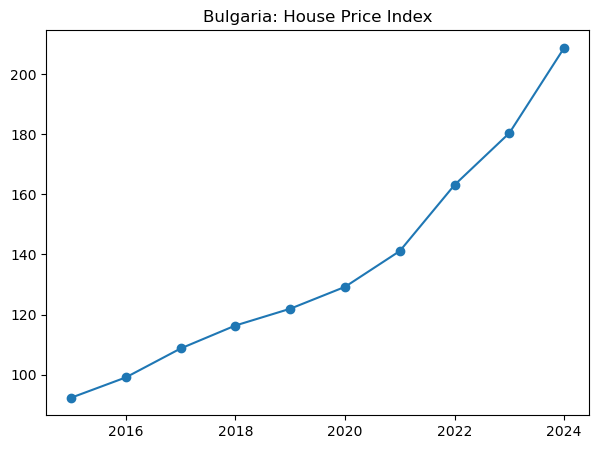

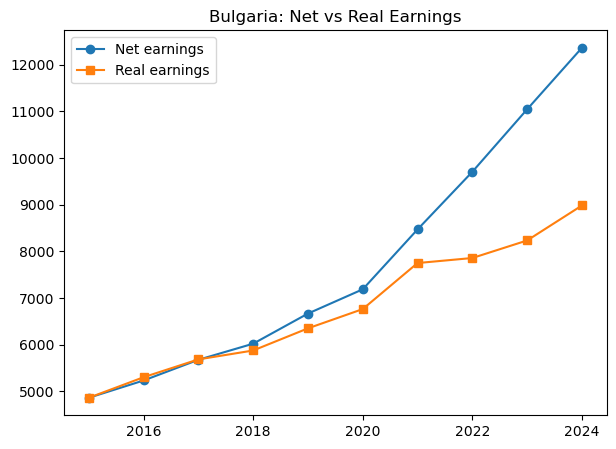

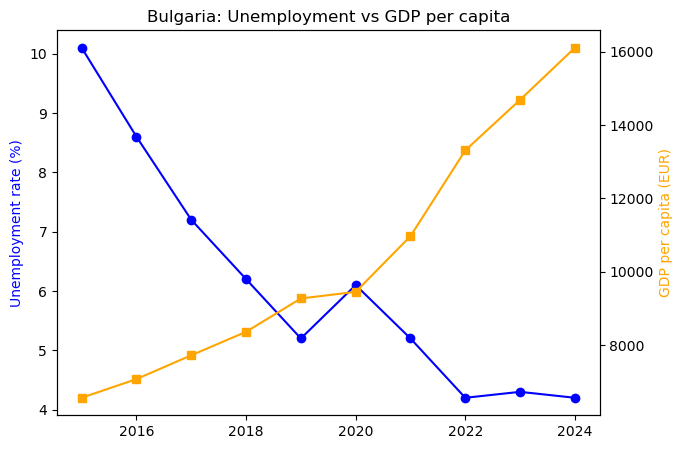

In [32]:
plt.plot(bg["year"], bg["house_price_index"], marker="o")
plt.title("Bulgaria: House Price Index")
plt.show()

plt.plot(bg["year"], bg["net_earnings"], marker="o", label="Net earnings")
plt.plot(bg["year"], bg["real_earnings"], marker="s", label="Real earnings")
plt.legend()
plt.title("Bulgaria: Net vs Real Earnings")
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(bg["year"], bg["unemployment_rate"], color="blue", marker="o")
ax1.set_ylabel("Unemployment rate (%)", color="blue")
ax2 = ax1.twinx()
ax2.plot(bg["year"], bg["gdp_per_capita"], color="orange", marker="s")
ax2.set_ylabel("GDP per capita (EUR)", color="orange")
plt.title("Bulgaria: Unemployment vs GDP per capita")
plt.show()